Lab #1
Due No Due Date Points 100 Submitting a website url or a file upload
Dear all --

Answer the following questions:

1-- Choose one variable, look at its distribution, and plot a histogram of it.  Explain what you take away from looking at the variable.

2-- Choose some continuous-ish variable, and calculate its mean and standard deviation by some grouping variable.  Explain what conclusion you draw from this analysis.

3-- Choose two categorical-ish variables, and cross-tabulate them.  Explain what conclusion you draw from this analysis.


In [3]:
USE_GSS = False
from __future__ import division
import os, re
import urllib.request; exec(urllib.request.urlopen('https://raw.githubusercontent.com/srhoads/srhoads/master/python/functions.py').read())
pkg('pandas'); import pandas as pd
pkg('numpy'); import numpy as np
pkg('statsmodels'); import statsmodels.api as sm
import statsmodels.formula.api as smf
pkg('colour'); from colour import Color
import matplotlib.pyplot as plt

def printurn(x):
    print(x)
    return(x)

def recode_onehot_if(s='CHILDRENS COAT', pattern='CHILDREN'):
    result = '1' if pattern in str(s) else '0'
    return(result)

def check_color(color):
    try:
        Color(color)
        return True
    except ValueError:
        return False

def extract_color(pdcolumn):
    pdcolumn = pd.Series(pdcolumn.copy()) if type(pdcolumn)==str else pd.Series(pdcolumn) if type(pdcolumn)==list else pdcolumn
    newcolumn = pdcolumn.copy().apply(lambda s: ' '.join([i for i in str(s).split(' ') if check_color(i)]))
    return(newcolumn)

def compute_percentage(x, my_crosstab):
      pct = float(x/my_crosstab['count'].sum()) * 100
      return round(pct, 2)

# extract_color(d.head().Description)
    # _color = [i for i in s.split(' ') if check_color(i)]
# s = 'light green'
# _color = [i for i in s.split(' ') if check_color(i)]

### Reading data below! We're using our own custom dataset (not the GSS data!). I found this sample retail sales dataset at this link: #https://www.kaggle.com/carrie1/ecommerce-data. I'm using this dataset because it aligns with my personal research interests and I wanted to make this lab as utilitarian as possible!

In [4]:
# # AREND CUSTOM (bc I personally hate downloading data files to my disk...):
if USE_GSS: # I'm not using GSS data for this lab, but if we wanted to, then we could grab the data straight from a URL (demo below).
    # try:
    #     import gssapi
    # except:
    #     os.system('pip install gssapi'); import gssapi
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen # or: requests.get(url).content
    resp = urlopen('http://gss.norc.org/documents/stata/2006_stata.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    dtafile = zipfile.namelist()[0]
    print(dtafile) # ['GSS2006.dta']
    d = pd.read_stata(zipfile.open(dtafile), convert_categoricals=False)
else:
    try: # NOTE: trying to read the csv file with basic default args first, but if error, we're adding the encoding argument. Since this dataset has text data, the encoding has some quirks and some Python & Pandas versions don't support it with default UTF-8 encoding.
        d = pd.read_csv('data.csv') # dataset is from #https://www.kaggle.com/carrie1/ecommerce-data
    except:
        d = pd.read_csv('data.csv', encoding="ISO-8859-1") #https://www.kaggle.com/carrie1/ecommerce-data
d

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


## I'm recoding some variables/creating new ones below! I'm also filtering the data so that it only has the observations we care about (valid UnitPrices and valid Quantity sold).

In [5]:
## df.loc[df.ID == 103, ['FirstName', 'LastName']] = 'Matt', 'Jones'
d_ = d.copy().apply(lambda y: y.str.lower() if str(y.dtype)=='object' else y).assign(
    children=lambda d: [recode_onehot_if(x, 'children') for x in d.Description],
    noun=lambda d: [str(x).split()[-1].strip() for x in d.Description],
    material=lambda d: d.Description.str.extract(r'(ceramic|metal|wood|plastic|cloth|felt|fabric|silk|polyester|linen|cotton|compostable|mahogany|canvas|cashmere|chiffon|denim|viscose|wool|fur|lace|leather|diamond|crystal|rhinestone|jewel|birch|rubber|wax|vintage|organic|pashmina|satin|spandex|suede|cement|marble)', expand=False, flags=re.IGNORECASE),
    # color=lambda d: d.Description.str.extract('\\b(pink|red|blue|white|green|yellow|purple|orange)\\b', expand=False, flags=re.IGNORECASE),
    color=lambda d: extract_color(d.Description),
    ).query('Quantity>=0 and UnitPrice>=0')
## d.assign(noun=lambda d: [str(x).split()[-1] for x in d.Description])
d_

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,children,noun,material,color
0,536365,85123a,white hanging heart t-light holder,6,12/1/2010 8:26,2.55,17850.0,united kingdom,0,holder,NaN,white
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,lantern,metal,white
2,536365,84406b,cream cupid hearts coat hanger,8,12/1/2010 8:26,2.75,17850.0,united kingdom,0,hanger,NaN,
3,536365,84029g,knitted union flag hot water bottle,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,bottle,NaN,
4,536365,84029e,red woolly hottie white heart.,6,12/1/2010 8:26,3.39,17850.0,united kingdom,0,heart.,wool,red white
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,12/9/2011 12:50,0.85,12680.0,france,0,napkins,NaN,
541905,581587,22899,children's apron dolly girl,6,12/9/2011 12:50,2.10,12680.0,france,1,girl,NaN,
541906,581587,23254,childrens cutlery dolly girl,4,12/9/2011 12:50,4.15,12680.0,france,1,girl,NaN,
541907,581587,23255,childrens cutlery circus parade,4,12/9/2011 12:50,4.15,12680.0,france,1,parade,NaN,


### Visualizing value counts & other descriptive statistics for the factors of our variable of interest (material)

In [6]:
# Checking value counts (frequencies) of words in the description field
pd.Series(' '.join(d_.Description.astype(str).unique().tolist()).split()).value_counts().head(20)

set          324
pink         300
of           241
heart        237
vintage      219
blue         214
red          198
bag          171
christmas    157
glass        156
box          134
white        131
design       129
holder       118
flower       115
small        114
metal        111
large        105
hanging      103
green        102
dtype: int64

In [20]:
# print(d_.noun.value_counts().head(20))
print(d_.value_counts().head(20))
# sorted(d_.noun.unique().tolist())

InvoiceNo  StockCode  Description                          Quantity  InvoiceDate       UnitPrice  CustomerID  Country         children  noun       material  color   
538517     22749      feltcraft princess charlotte doll    1         12/12/2010 16:05  3.75       17618.0     united kingdom  0         doll       felt                  5
550331     85202      hanging wood and felt heart          1         4/17/2011 13:43   0.42       15555.0     united kingdom  0         heart      wood                  5
578041     22326      round snack boxes set of4 woodland   1         11/22/2011 14:23  2.95       17338.0     united kingdom  0         woodland   wood                  4
572861     21669      blue stripe ceramic drawer knob      6         10/26/2011 12:46  1.45       14102.0     united kingdom  0         knob       ceramic   blue        4
580908     22139      retrospot tea set ceramic 11 pc      1         12/6/2011 13:20   4.95       16495.0     united kingdom  0         pc         cer

In [21]:
d_.material.value_counts()

wood         25479
metal        21103
felt          9730
ceramic       8874
lace          3760
jewel         1874
crystal       1309
cloth          939
cotton         887
silk           777
marble         690
fabric         682
wool           559
polyester      404
canvas         299
plastic        285
rubber         125
linen          120
denim           61
diamond         59
fur             50
suede           24
Name: material, dtype: int64

In [22]:
summary = d_.material.describe()
summary.transpose()

count     78090
unique       22
top        wood
freq      25479
Name: material, dtype: object

In [23]:
## Crosstabulation (like in Eirich's example!)
my_crosstab = pd.crosstab(index=d_["material"], columns="count")     
my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
my_crosstab.sort_values('percentage', ascending=False)

col_0,count,percentage
material,,
wood,25479,32.63
metal,21103,27.02
felt,9730,12.46
ceramic,8874,11.36
lace,3760,4.81
jewel,1874,2.40
crystal,1309,1.68
cloth,939,1.20
cotton,887,1.14


Below is a histogram of material! It's just demoing the value counts (which I explain below).

<AxesSubplot:>

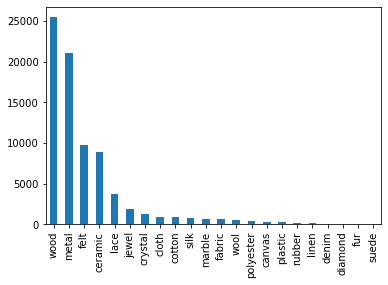

In [24]:
d_['material'].value_counts().plot(kind='bar')

# Answer to Q 1:

<h3>
1-- The variable upon which I'm focusing is one that I custom-created from a text variable. Using the "Description" variable of the retail item in my sales dataset, I found that many of the described items include their materials (ie: metal, ceramic, wood, etc...). I thought this variable would be interesting because different materials of retail items might have different sales patterns (price, quantity, or even date/location purchased). 

I'm most interested in fashion-related retail items, so I defined a list of materials that I wanted to extract from the description column. I also included the code "vintage" even though it's not a specific material because it connotes a type of quality. This is a very rough first-go at defining a material list, but it's useful for now. The value counts are listed in the cell above. The most common codes are vintage, wood, metal, felt, and ceramic. Less common materials listed in item descriptions are diamond, fur, suede, wax.

As shown in the crosstabulation table above, 30.05% of the records have the "vintage" code. This isn't really a material, so I think I might recode it as a separate variable. Vintage must be a popular description in retail sales though!
The other factors with substantial percentages of the total are "wood" at 23.02%, "metal" at 18.97%, "felt" at 8.74%,"ceramic" at 8.17%, "lace" at 3.39%, "jewel" at 1.72%, and "crystal" at 1.17% of the observations. The other material factors make up under 1%. I could be more specific with some of these codes. For example, I could look for text including specific types of metal instead of "metal" at large.
    
</h3>

### In the cell below, I am removing the "vintage" code from the "material" variable.

In [25]:
d_['material'] = d_['material'].replace({'vintage': np.NaN}, regex=False)
d_['material'].value_counts()

wood         25479
metal        21103
felt          9730
ceramic       8874
lace          3760
jewel         1874
crystal       1309
cloth          939
cotton         887
silk           777
marble         690
fabric         682
wool           559
polyester      404
canvas         299
plastic        285
rubber         125
linen          120
denim           61
diamond         59
fur             50
suede           24
Name: material, dtype: int64

# Answer to Q2:
*Question: 2-- Choose some continuous-ish variable, and calculate its mean and standard deviation by some grouping variable.  Explain what conclusion you draw from this analysis.*

### For the histograms, I cropped the min and max X values to be more intuitive to the range of possibilities in the data itself. Quantity of item purchased can't ever be negative, so I restricted the X min to a quantity of 0.

count    531283.000000
mean         10.655299
std         156.830617
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64


array([[<AxesSubplot:title={'center':'Quantity'}>]], dtype=object)

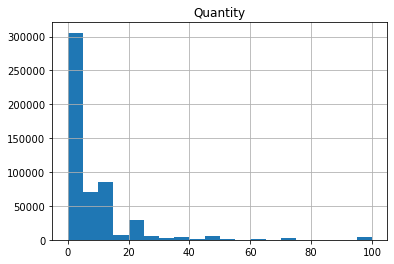

In [26]:
print(d_.Quantity.describe())
d_.hist(column='Quantity', range=(0, 100), bins=20)

count    531283.000000
mean          3.898954
std          35.876279
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64


array([[<AxesSubplot:title={'center':'UnitPrice'}>]], dtype=object)

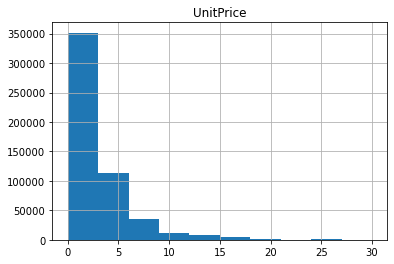

In [27]:
print(d_.UnitPrice.describe())
d_.hist(column='UnitPrice', range=(0, 30))

In [28]:
print('Mean of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].mean().sort_values(ascending=False), '\n\n')
print('Median of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].median().sort_values(ascending=False), '\n\n')
print('Standard Deviation of material x UnitPrice:\n\n', d_.groupby(['material'])['UnitPrice'].std().sort_values(ascending=False), '\n\n')
print('Count of material x UnitPrice (meaning unique unit prices per each material):\n\n', d_.groupby(['material'])['UnitPrice'].count().sort_values(ascending=False), '\n\n')

Mean of material x UnitPrice:

 material
fur          18.764600
diamond       8.883051
jewel         4.927753
wool          4.312648
wood          3.749006
cotton        3.741364
linen         3.593833
lace          3.500598
suede         3.400000
cloth         3.285293
felt          2.934777
metal         2.811265
ceramic       2.417493
canvas        1.891973
silk          1.870425
crystal       1.835095
denim         1.670328
polyester     1.479703
fabric        1.349868
rubber        1.009920
marble        0.957478
plastic       0.736140
Name: UnitPrice, dtype: float64 


Median of material x UnitPrice:

 material
fur          19.95
diamond       5.95
wool          4.25
jewel         4.25
linen         3.29
felt          2.95
suede         2.95
cotton        2.95
lace          2.95
metal         2.10
wood          1.95
cloth         1.65
denim         1.65
canvas        1.65
silk          1.63
crystal       1.63
polyester     1.45
ceramic       1.45
marble        0.85
fabric        

In [29]:
print('Mean of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].mean(), '\n\n')
print('Median of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].median(), '\n\n')
print('Standard Deviation of material x Quantity:\n\n', d_.groupby(['material'])['Quantity'].std(), '\n\n')
print('Count of material x Quantity (meaning unique quantity levels purchased per each material):\n\n', d_.groupby(['material'])['Quantity'].count(), '\n\n')

Mean of material x Quantity:

 material
canvas        9.056856
ceramic      18.659905
cloth         9.782748
cotton        3.330327
crystal       5.854087
denim         3.540984
diamond       3.355932
fabric        9.065982
felt          7.985098
fur           1.760000
jewel         8.716115
lace         10.346277
linen         4.675000
marble       23.178261
metal         8.592049
plastic       9.375439
polyester    11.279703
rubber       10.280000
silk         31.839125
suede         3.666667
wood          9.155226
wool         10.787120
Name: Quantity, dtype: float64 


Median of material x Quantity:

 material
canvas        3
ceramic       6
cloth         3
cotton        2
crystal       2
denim         3
diamond       2
fabric        4
felt          4
fur           1
jewel         2
lace          3
linen         6
marble       12
metal         3
plastic       4
polyester     4
rubber        2
silk          8
suede         3
wood          3
wool          4
Name: Quantity, dtype: int

### Let's try grouping these variables by material! Material could be an interesting metric alongside price and quantity of items.

In [30]:
## Crosstabulation (like in Eirich's example!)
# pd.crosstab(d_.material, [d_.UnitPrice, d.Quantity], rownames=['material'], colnames=['UnitPrice', 'Quantity'])
pd.crosstab(d_.material, [d_.UnitPrice], rownames=['material'], colnames=['UnitPrice'])
# my_crosstab['percentage'] = my_crosstab.apply(lambda y: compute_percentage(y, my_crosstab), axis=1)
# my_crosstab.sort_values('percentage', ascending=False)

UnitPrice,0.00,0.04,0.12,0.19,0.20,0.21,0.22,0.25,0.27,0.29,...,34.95,39.95,39.96,49.96,78.29,85.00,110.00,125.00,175.00,195.00
material,,,,,,,,,,,,,,,,,,,,,
canvas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ceramic,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cloth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cotton,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
crystal,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
denim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
diamond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fabric,0,0,0,11,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
felt,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
pd.crosstab(d_.material, [d_.Quantity], rownames=['material'], colnames=['Quantity'])

Quantity,1,2,3,4,5,6,7,8,9,10,...,720,840,864,900,1200,1296,1350,1404,2000,74215
material,,,,,,,,,,,,,,,,,,,,,
canvas,85,51,22,12,5,11,3,9,0,2,...,0,0,0,0,0,0,0,0,0,0
ceramic,1668,1129,685,804,93,828,51,177,46,57,...,0,0,0,0,0,0,1,0,0,1
cloth,233,190,60,52,19,24,3,8,1,6,...,0,0,0,0,0,0,0,0,0,0
cotton,403,171,49,34,14,174,1,10,0,0,...,0,0,0,0,0,0,0,0,0,0
crystal,584,188,91,58,31,97,11,10,5,12,...,0,0,0,0,0,0,0,0,0,0
denim,19,11,13,5,1,3,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
diamond,29,15,3,1,0,2,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
fabric,191,80,35,37,46,36,5,7,4,83,...,0,0,0,0,0,0,0,0,0,0
felt,2809,1216,616,1592,153,1027,30,312,16,40,...,3,2,0,0,0,3,0,0,0,0


In [32]:
my_crosstab

col_0,count,percentage
material,,
canvas,299,0.38
ceramic,8874,11.36
cloth,939,1.20
cotton,887,1.14
crystal,1309,1.68
denim,61,0.08
diamond,59,0.08
fabric,682,0.87
felt,9730,12.46


<h2>
Analysis
</h2>

<h4>
Based on the descriptive statistics above, when analysing the mean price grouped by the categorical variable material, we observe that fur on average is the most expensive item purchased. On the contrary, plastic is the cheapest item. 

When analysing the standard deviation of the categorical variable material grouped by its unit price, denim is the most consistent material purchased at a similar price, whilst diamond is the most erratic material purchased when a consumer purchases an item from the company in terms of its unit pricing. There could be several reasons for this: denim is perhaps the most common, and most casual material used when an individual dresses or wants to go out. As a consequence, since it is such an ubiquitous material and item used amongst consumers, there is more supply from vendors which standardises the pricing of items with denim material. Conversely, with diamond, a luxury material exacerbated by a scattered industry where prices are not simply quoted, it is not surprising to data analysts to observe these items be inconsistently priced. 

There are confounds here because some of these items do not have the construct validity that is rightfully supposed to have. For example, cloth encompasses a wide range of material, possibly entailing materials listed in the same data set i.e. cotton, lace etc. They are all cloth material but they are treated as mutually exclusive entities.  We also aren’t accounting for variations in quality. Diamond, for example, has different grades of material, whereas denim is a lot more uniform. Our data set printed does not account for these different grades of the same material. In some ways, we are comparing apples and oranges, and if we have to report on these numbers, we should try to compile statistics that have more construct validity, and fewer issues with collinearity. 
 </h4>

# Answer to Q3:
*3-- Choose two categorical-ish variables, and cross-tabulate them.  Explain what conclusion you draw from this analysis.
*

### material by country

In [33]:
pd.crosstab(d_.material, [d_.Country], rownames=['material'], colnames=['Country'])


Country,australia,austria,bahrain,belgium,brazil,canada,channel islands,cyprus,czech republic,denmark,...,rsa,saudi arabia,singapore,spain,sweden,switzerland,united arab emirates,united kingdom,unspecified,usa
material,,,,,,,,,,,,,,,,,,,,,
canvas,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,285,0,0
ceramic,17,17,2,17,0,1,13,6,0,2,...,1,0,1,65,4,42,3,7987,2,10
cloth,0,0,0,3,0,0,1,0,0,0,...,0,0,1,1,0,5,0,811,0,0
cotton,4,3,0,3,0,0,0,0,0,3,...,1,1,0,11,0,1,0,779,0,2
crystal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1298,0,0
denim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,57,0,0
diamond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,57,1,0
fabric,0,0,0,1,0,0,0,0,0,0,...,0,0,0,4,1,2,0,632,2,0
felt,28,5,0,13,0,0,25,46,3,0,...,0,0,2,46,4,15,0,9116,14,2


Based on the descriptive statistics above (cross-tabulating two categorical variables, country and material), there are some obvious conclusions that we can draw. First, since this is a UK retailer, it is not uncommon to see the most purchases(regardless of material), come from local consumers. Swiss consumers purchased the most amount of wood in comparison to other countries like Denmark, Saudi Arabia. We could think that it is logical for there to be a higher demand of wood in Swiss consumers than Saudi Arabian consumers because the climate is not optimal using wood for building, since wood is in prime condition in humid areas and at average temperatures. The dry climate in Saudia Arabia would not suit wood for building purposes. Based on the data set above, a conclusion that we could draw is that we require a narrowed down data set of countries so as to really analyze the material purchased based off geographical region. A way to do this could be by recoding the country variable as a new variable (continent for example).


In [34]:
#os.system("pip install pycountry-convert")
import pycountry_convert as pc
country_code = pc.country_name_to_country_alpha2("United Kingdom", cn_name_format="default")
print(country_code)

GB


In [35]:
continent_name = pc.country_alpha2_to_continent_code(country_code)
print(continent_name)


EU


In [36]:
# d_.Country

new_list = []
for boob in d_.Country.str.title():
    try:
        new_boob = pc.country_name_to_country_alpha2(boob, cn_name_format="default")
        new_boob = pc.country_alpha2_to_continent_code(new_boob)
#         print(new_boob)
    except:
        new_boob = ''
    new_list.append(new_boob)

In [37]:
d_['continent'] = new_list

In [41]:
## For the sake of continent-code clarification, here's which codes are associated with which continents:
# Code	Continent name
# AF	Africa
# AN	Antarctica
# AS	Asia
# EU	Europe
# NA	North america
# OC	Oceania
# SA	South america

# And here are our new continent value counts!
d_.continent.value_counts()

EU    518654
        9385
AS      1876
OC      1185
NA       151
SA        32
Name: continent, dtype: int64

In [42]:
pd.crosstab(d_.material, [d_.continent], rownames=['material'], colnames=['continent'])

continent,,AS,EU,NA,OC,SA
material,,,,,,
canvas,6,1,292,0,0,0
ceramic,162,25,8669,1,17,0
cloth,26,4,909,0,0,0
cotton,19,2,862,0,4,0
crystal,6,0,1303,0,0,0
denim,1,0,60,0,0,0
diamond,2,0,57,0,0,0
fabric,11,2,669,0,0,0
felt,169,57,9476,0,28,0


### Based on the above data set grouping these materials by continent, we have a much clearer picture. For starters, wood, like we've already mentioned in the first analysis, is most heavily purchased in Europe in comparison to Asia and South America. And this is rightfully so with the more suitable climate conditions in Europe for wood. There are other interesting observations such as diamond being more heavily purchased in Europe than in Asia. This could be because most luxury fashion brands are stationed in Europe, like Pandora for example, who have built a reputation as a reliable diamond maker for jewellery.  

# IGNORE THE FOLLOWING STUFF.....

In [20]:
try:
    from census import Census
    from us import states
except:
        os.system('pip install census, us, CensusData')
CENSUS_API_KEY = os.getenv('CENSUS_API_KEY')
c = Census(CENSUS_API_KEY)
# c.acs5.get(('NAME', 'B25034_010E'),{'for': 'state:{}'.format(states.MD.fips)})
# c.acs5.state(('NAME', 'B25034_010E'), states.MD.fips)
# import requests
# s = requests.session()
# s.headers.update({'User-Agent': 'census-demo/0.0'})

# c = Census(CENSUS_API_KEY, session=s)
# c.acs5.state('B01001_004E', Census.ALL)
os.environ
c.sf1.get('NAME', geo={'for': 'tract:*', 'in': 'state:{} county:170'.format(states.AK.fips)})

In [50]:
# print(d.columns.tolist())
os.system('pip install kaggle')
'kaggle datasets download -d PromptCloudHQ/innerwear-data-from-victorias-secret-and-others'

import requests
url="https://www.kaggle.com/carrie1/ecommerce-data/download"
r = requests.get(url)
r.headers


{'Date': 'Tue, 11 May 2021 15:41:10 GMT', 'Content-Type': 'text/html; charset=utf-8', 'Cache-Control': 'no-cache, no-store', 'Pragma': 'no-cache', 'Content-Encoding': 'gzip', 'Set-Cookie': 'CSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL9lMxVZH7go3KhI5uRsDH7EhEyP6NS697CKxdPH2fGtgVmXj1wZBgVOaaWP0wIOnoYXKeApe1xIWJLYuM2vGG2olRIeiGJ32JircBagOHWfzrtRY5fTJ7yRq-RRxOtw02U; path=/; secure; samesite=lax; httponly, XSRF-TOKEN=CfDJ8LdUzqlsSWBPr4Ce3rb9VL9uVWGo7mPpEqCqhZTe-khEbedvBdyBrkGAmLE2GSfBU26Rc-O9saQAPbZNpQct-xUCy4XkL-mQPLcdP85eUHX_L7Mb0xBLTNKl1dChyXrWSlSAomLN38VKpUv2Ewv-AaU; path=/; secure; samesite=lax, CLIENT-TOKEN=eyJhbGciOiJub25lIiwidHlwIjoiSldUIn0.eyJpc3MiOiJrYWdnbGUiLCJhdWQiOiJjbGllbnQiLCJzdWIiOm51bGwsIm5idCI6IjIwMjEtMDUtMTFUMTU6NDE6MTAuNjUyMDQ2N1oiLCJpYXQiOiIyMDIxLTA1LTExVDE1OjQxOjEwLjY1MjA0NjdaIiwianRpIjoiMzkwYzRjMDItYzBmZS00MDhmLWE3YTMtYzhhMjljNWEyNGFiIiwiZXhwIjoiMjAyMS0wNi0xMVQxNTo0MToxMC42NTIwNDY3WiIsImFub24iOnRydWUsImZmIjpbIkp1cHl0ZXJMYWIiLCJEb2NrZXJNb2RhbFNlbGVjdG9yIiwiQWN0aXZlRXZlbnRzIiw

In [52]:
# import requests, csv
# from contextlib import closing
# url = 'https://www.kaggle.com/carrie1/ecommerce-data/download'
# with closing(requests.get(url, stream=True)) as r:
#     reader = csv.reader(r.iter_lines(), delimiter=',', quotechar='"')
# #     for row in reader:
# #         print(row)
#     [print(row) for row in reader]
import csv
import requests
CSV_URL = 'https://www.kaggle.com/carrie1/ecommerce-data/download'
with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    for row in my_list:
        print(row)

['<!DOCTYPE html>']
['<html lang="en">']
[]
['<head>']
['  <title>Kaggle: Your Home for Data Science</title>']
['  <meta charset="utf-8" />']
['  <meta name="robots" content="index', ' follow" />']
['  <meta name="description" content="Kaggle is the world&#x2019;s largest data science community with powerful tools and resources to help you achieve your data science goals." />']
['  <meta name="turbolinks-cache-control" content="no-cache" />']
['    <meta name="viewport" content="width=device-width', ' initial-scale=1.0', ' maximum-scale=5.0', ' minimum-scale=1.0">']
['  <meta name="theme-color" content="#008ABC" />']
['  <script nonce="3DB7gUmU3HMgAPHxPXpWng==" type="text/javascript">']
["    if ('serviceWorker' in navigator) {"]
['      navigator.serviceWorker.getRegistrations()']
['        .then(function (registrations) {']
['          for (let registration of registrations) {']
['            registration.unregister();']
['          }']
['        })']
['        .catch(function (err) 

## Sample answer to Q 1:
    
1-- I chose to look at a variable that investigates one of the Big Five dimensions of personality, as developed by psychologists. This variable, ​big5a1​, is the respondent's level of agreement to the following statement: I see myself as someone who is reserved; so it is basically a measure of introversion.

As Table 1 indicates, valid answers range from 1 to 5, where 1 represents strongagreement and 5 indicates strong disagreement (3=neither agreement or disagreement).

The below table, Table 2, shows that a large plurality of Americans (42%) agree that they are reserved, while only roughly a quarter of Americans assert they are not reserved (21% disagreeand only 7% strongly disagree). It is somewhat surprising how few Americans think of themselves as outgoing or bold, and yet few think of themselves as extremely shy (i.e., only 13% of people ​strongly​ agree they are reserved).

There is a histogram of this variable as well, which represents the same results of what I was talking about.

From the codebook, Table 1 is:

1019) I see myself as someone who is reserved. (BIG5A1) TOTAL % 1) Strongly agree 200 13.2 2) Agree 632 41.6 3) Neither agree nor disagree 253 16.7 4) Disagree 317 20.9 5) Strongly disagree 102 6.7 8) Can't choose 12 0.8 9) No answer 2 0.1 Missing 2992 TOTAL 1518 100

In [26]:
# os.chdir('C:/Users/gme2101/Desktop/Data Analysis Data') # change working directory

# ## I am using the codebook at http://www.thearda.com/Archive/Files/Codebooks/GSS2006_CB.asp ##

# d = pd.read_csv("GSS.2006.csv")
# d.head()